# UNET SEGMENTATION

Arxiv Link: <a href="https://arxiv.org/abs/1505.04597">U-Net: Convolutional Networks for Biomedical Image Segmentation</a>

<ul>
<li>UNet is a fully convolutional network(FCN) that does image segmentation. Its goal is to predict each pixel's class.</li>
 
<li>UNet is built upon the FCN and modified in a way that it yields better segmentation in medical imaging.</li>
</ul>

## 1.1 Architecture

<img src="images/u-net-architecture.png"/>

<h3>UNet Architecture has 3 parts:</h3>
<ol>
    <li>The Contracting/Downsampling Path</li>
    <li>Bottleneck</li>
    <li>The Expanding/Upsampling Path</li>
</ol>

<h3>Downsampling Path: </h3> 
<ol>
    <li>It consists of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.</li> 
    <li>At each downsampling step we double the number of feature channels.</li>
</ol>

<h3>Upsampling Path: </h3> 
<ol>
     <li> Every  step  in  the  expansive  path  consists  of  an  upsampling  of  the feature map followed by a 2x2 convolution (“up-convolution”), a concatenation with the correspondingly feature  map  from  the  downsampling  path,  and  two  3x3  convolutions,  each  followed by a ReLU.</li>
</ol>

<h3> Skip Connection: </h3>
The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connection provide local information to global information while upsampling.

<h3> Final Layer: </h3>
At the final layer a 1x1 convolution is used to map each feature vector to the desired number of classes.

## 1.2 Advantages
<h3> Advantages: </h3>
<ol>
    <li>The UNet combines the location information from the downsampling path to finally obtain a general information combining localisation and context, which is necessary to predict a good segmentation map.</li>
    <li>No Dense layer is used, so image sizes can be used.</li>
</ol>

## 1.3 Dataset
Link: <a href="https://www.kaggle.com/c/data-science-bowl-2018">Data Science Bowl 2018</a>
Find the nuclei in divergent images to advance medical discovery

## 1.4 Code

In [1]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import tensorflow as tf
import pywt
from tensorflow import keras

import matplotlib.pyplot as plt

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Data Generator

In [2]:
# class DataGen(keras.utils.Sequence):
#     def __init__(self, ids, path, batch_size=8, image_size=128):
#         self.ids = ids
#         self.path = path
#         self.batch_size = batch_size
#         self.image_size = image_size
#         self.on_epoch_end()
        
#     def __load__(self, id_name):
#         ## Path
#         # image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
#         # mask_path = os.path.join(self.path, id_name, "masks/")
#         # all_masks = os.listdir(mask_path)
        
#         # ## Reading Image
#         # image = cv2.imread(image_path, 1)
#         # image = cv2.resize(image, (self.image_size, self.image_size))
        
#         # mask = np.zeros((self.image_size, self.image_size, 1))
        
#         # ## Reading Masks
#         # for name in all_masks:
#         #     _mask_path = mask_path + name
#         #     _mask_image = cv2.imread(_mask_path, -1)
#         #     _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
#         #     _mask_image = np.expand_dims(_mask_image, axis=-1)
#         #     mask = np.maximum(mask, _mask_image)
            
#         # ## Normalizaing 
#         # image = image/255.0
#         # mask = mask/255.0
#         image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
#         mask_path = os.path.join(self.path, id_name, "masks/")
#         all_masks = os.listdir(mask_path)
        
#         ## Reading Image
#         image = cv2.imread(image_path, 1)
#         image = cv2.resize(image, (self.image_size, self.image_size))
        
#         mask = np.zeros((self.image_size, self.image_size, 1))
        
#         ## Reading Masks
#         for name in all_masks:
#             _mask_path = mask_path + name
#             _mask_image = cv2.imread(_mask_path, -1)
#             _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
#             _mask_image = np.expand_dims(_mask_image, axis=-1)
#             mask = np.maximum(mask, _mask_image)

#         # Apply wavelet transformation (Haar wavelet)
#         coeffs = pywt.dwt2(image, 'haar')
#         LL, (LH, HL, HH) = coeffs
#         image = LL  # Use approximation coefficients after wavelet transformation

#         return image, mask

#         # return image, mask
    
#     def __getitem__(self, index):
#         if(index+1)*self.batch_size > len(self.ids):
#             self.batch_size = len(self.ids) - index*self.batch_size
        
#         files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
#         image = []
#         mask  = []
        
#         for id_name in files_batch:
#             _img, _mask = self.__load__(id_name)
#             image.append(_img)
#             mask.append(_mask)
            
#         image = np.array(image)
#         mask  = np.array(mask)
        
#         return image, mask
    
#     def on_epoch_end(self):
#         pass
    
#     def __len__(self):
#         return int(np.ceil(len(self.ids)/float(self.batch_size)))
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        # Read and preprocess the image
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        print( image_path)
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size))
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
        
        # Apply wavelet transformation (Haar wavelet)
        coeffs = pywt.dwt2(image, 'haar')
        LL, (LH, HL, HH) = coeffs
        image = LL  # Use approximation coefficients after wavelet transformation
        
        image = np.reshape(image, (image.shape[0], image.shape[1], -1))
    
    # Resize the dimensions to match the expected shape
        image = cv2.resize(image, (128, 128))
        image = np.concatenate([image, image[:, :, 1:2]], axis=-1)
        # Normalize the image
        image = image / 255.0
        mask = mask / 255.0
        
        return image, mask
        
            
    
    
    def __getitem__(self, index):
        # Load data for a batch
        if (index + 1) * self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size
        
        files_batch = self.ids[index * self.batch_size : (index + 1) * self.batch_size]
        
        image = []
        mask = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids) / float(self.batch_size)))

# Assuming model is your Keras model
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

# Assuming your model architecture expects input of shape (128, 128, 3)
# model.compile(optimizer='adam', loss='binary_crossentropy')  # Adjust loss function as needed

# model.fit(train_gen, validation_data=valid_gen, epochs=epochs, steps_per_epoch=len(train_gen), validation_steps=len(valid_gen))


NameError: name 'train_ids' is not defined

## Hyperparameters

In [ ]:
image_size = 128
train_path = "dataset/stage1_train/"
epochs = 5
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path))[1]
# train_ids = [dir for dir in next(os.walk(train_path))[1]]
## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


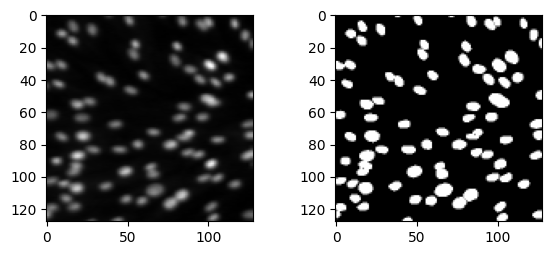

In [ ]:

r = random.randint(0, len(x)-1)

# fig = plt.figure()
# fig.subplots_adjust(hspace=0.4, wspace=0.4)
# ax = fig.add_subplot(1, 2, 1)
# ax.imshow(x[r])
# ax = fig.add_subplot(1, 2, 2)
# ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")
# Generate a random index
r = random.randint(0, len(x)-1)

# Create a figure and subplots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot the original image
ax = fig.add_subplot(1, 2, 1)
# Since the image has been transformed by wavelet, you may need to reshape it
# For example, if LL is the transformed image, you can plot it like this:
# ax.imshow(x[r], cmap='gray')  # Assuming the transformed image is grayscale
# Assuming the transformed image has a shape of (128, 64, 3) after wavelet transformation
ax.imshow(x[r][:, :, 0], cmap='gray')  # Display the first channel of the RGB image as grayscale

# If LL is a multi-channel image, you need to select one channel for display

# Plot the corresponding mask
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")  # Assuming y contains masks


## Different Convolutional Blocks

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## UNet Model

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 128, 128,  │        448 │ input_layer_10[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 128, 128,  │      2,320 │ conv2d_190[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_40    │ (None, 64, 64,    │          0 │ conv2d_191[0][0]  │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 64, 64,    │      4,640 │ max_pooling2d_40… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_193 (Conv2D) │ (None, 64, 64,    │      9,248 │ conv2d_192[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_41    │ (None, 32, 32,    │          0 │ conv2d_193[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_194 (Conv2D) │ (None, 32, 32,    │     18,496 │ max_pooling2d_41… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_195 (Conv2D) │ (None, 32, 32,    │     36,928 │ conv2d_194[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_42    │ (None, 16, 16,    │          0 │ conv2d_195[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_196 (Conv2D) │ (None, 16, 16,    │     73,856 │ max_pooling2d_42… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_197 (Conv2D) │ (None, 16, 16,    │    147,584 │ conv2d_196[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_43    │ (None, 8, 8, 128) │          0 │ conv2d_197[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_198 (Conv2D) │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_43… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_199 (Conv2D) │ (None, 8, 8, 256) │    590,080 │ conv2d_198[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_40    │ (None, 16, 16,    │          0 │ conv2d_199[0][0]  │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_40      │ (None, 16, 16,    │          0 │ up_sampling2d_40… │
│ (Concatenate)       │ 384)              │            │ conv2d_197[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,962,625 (7.49 MB)

 Trainable params: 1,962,625 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=int(train_steps), validation_steps=int(valid_steps), 
                    epochs=epochs)

Epoch 1/5
65/82 ━━━━━━━━━━━━━━━━━━━━ 8s 519ms/step - acc: 0.8060 - loss: 0.6768

## Testing the model

In [ ]:
## Save the Weights
model.save_weights("UNet.weights.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


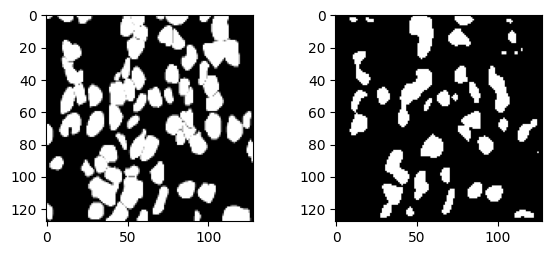

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

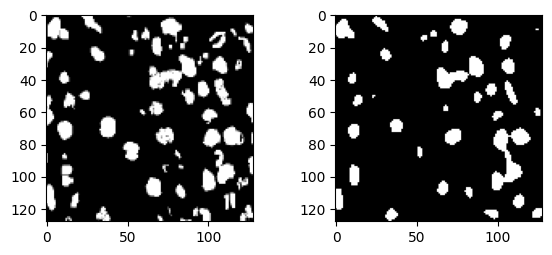

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")